In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import sleep
from IPython.display import HTML
from matplotlib import animation
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

from mpl_toolkits.mplot3d import Axes3D

import os,pickle

def create_if_not_exists(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path


create_if_not_exists('./movies-4d/')
create_if_not_exists('./cache/')

np.set_printoptions(precision=4,)
plt.style.use('ggplot')

import matplotlib
print(matplotlib.__version__)

2.2.3


Настройки:
* use_cache &ndash; использовать кэш
* plt_size &ndash; размер точек сетки
* plt_alpha &ndash; настройка прозрачности
* render_fps &ndash; частота кадров в анимации
* compute_fps &ndash; частота кадров при моделировании

In [2]:
#settings
use_cache = True

plt_size = 5
plt_alpha = 0.1

render_fps = 30
compute_fps = 60

Настройки симуляции:
* LL &ndash; размер кубической сетки
* NN &ndash; число точек сетки по каждому направлению
* T &ndash; число секунд, которые мы считаем
* L(x|y|z) &ndash; размер сетки по одному направлению (для некубической сетки)
* N(x|y|z) &ndash; число точек сетки по одному направлению (для некубической сетки)
* h(x|y|z) &ndash; шаг сетки по одному направлению (вычисляется)
* Nt &ndash; число кадров к просчету
* ht &ndash; шаг сетки по времени

In [3]:
LL = np.pi
NN = 31
T = 10

Lx = LL
Nx = NN
hx = Lx/Nx

Ly = LL
Ny = NN
hy = Ly/Ny

Lz = LL
Nz = NN
hz = Lz/Nz

Nt = T * compute_fps
ht = T/Nt

In [4]:
cache_filename = '{}_{}_{}_{}.pickle'

Настройки граничных условий:
* is_periodic_(x|y|z) &ndash; граничное условие по координате является периодическим

In [5]:
is_periodic_x = True
is_periodic_y = True
is_periodic_z = True

Посмотрим, как выглядит функция $\varphi(i,j,k)$

In [10]:
def plot_phi():
    _,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':'3d'})
    x = np.array(range(0,Nx+1))
    y = np.array(range(0,Ny+1))
    z = np.array(range(0,Nz+1))
    
    X,Y,Z = np.meshgrid(x,y,z)
    C = v_phi(X,Y,Z)
    blue_vec = np.array([1,0,0,plt_alpha])
    red_vec = np.array([0,0,1,plt_alpha])
    
    plt_X = X.reshape((-1,))
    plt_Y = Y.reshape((-1,))
    plt_Z = Z.reshape((-1,))
    plt_C = C.reshape((-1,))
    print(plt_C.min(),plt_C.max())
    cmhot = plt.cm.get_cmap('bwr')
    
    gr = ax.scatter(plt_X,plt_Y,plt_Z,s=plt_size,c=plt_C,alpha=plt_alpha,cmap=cmhot)
    
    ax.set_xbound(0 - 0.1,Nx + 0.1)
    ax.set_ybound(0 - 0.1,Ny + 0.1)
    ax.set_zbound(0 - 0.1,Nz + 0.1)
    plt.show()
    return

-0.9999879897221092 0.9983015854887547


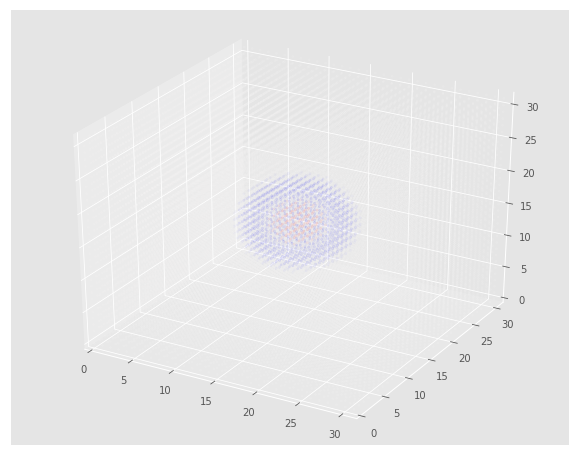

In [11]:
def phi(i,j,k):
    x = i*hx
    y = j*hy
    z = k*hz
    res = 0
    res += 1 * np.sin(np.minimum(9*np.sqrt((x-Lx/2)**2+(y-Ly/2)**2+(z-Lz/2)**2),2*np.pi))
    return res

v_phi = np.vectorize(phi,signature='(n,m,k),(n,m,k),(n,m,k)->(n,m,k)')

plot_phi()

Просчитаем сетку

In [8]:
# start
u = np.zeros((Nt,Nx+1,Ny+1,Nz+1))

for n in tqdm(range(0,Nt)):
    if n == 0:
        for i in range(1,Nx):
            for j in range(1,Ny):
                for k in range(1,Nz):
                    u[n,i,j,k] = phi(i,j,k)
    elif n == 1:
        for i in range(1,Nx):
            for j in range(1,Ny):
                for k in range(1,Nz):
                    u[n,i,j,k] = u[n-1,i,j,k] + ht**2/2 * (
                        (phi(i+1,j,k) - 2*phi(i,j,k) + phi(i-1,j,k))/hx**2
                        +(phi(i,j+1,k) - 2*phi(i,j,k) + phi(i,j-1,k))/hy**2
                        +(phi(i,j,k+1) - 2*phi(i,j,k) + phi(i,j,k-1))/hz**2
                    )
    else:
        for i in range(1,Nx):
            for j in range(1,Ny):
                for k in range(1,Nz):
                    u[n,i,j,k] = 2*u[n-1,i,j,k]-u[n-2,i,j,k] + ht**2 * (
                        (u[n-1,i+1,j,k] - 2*u[n-1,i,j,k] + u[n-1,i-1,j,k])/hx**2
                        +(u[n-1,i,j+1,k] - 2*u[n-1,i,j,k] + u[n-1,i,j-1,k])/hy**2
                        +(u[n-1,i,j,k+1] - 2*u[n-1,i,j,k] + u[n-1,i,j,k-1])/hz**2)
# ВНИМАНИЕ, тут написана фигня
# Это неправильные периодические условия!
    if is_periodic_x:
        for j in range(0,Ny+1):
            for k in range(0,Nz+1):
                u[n,0,j,k] = u[n,Nx-1,j,k]
                u[n,Nx,j,k] = u[n,1,j,k]
    if is_periodic_y:
        for i in range(0,Nx+1):
            for k in range(0,Nz+1):
                u[n,i,0,k] = u[n,i,Ny-1,k]
                u[n,i,Ny,k] = u[n,i,1,k]
    if is_periodic_z:
        for i in range(0,Nx+1):
            for j in range(0,Ny+1):
                u[n,i,j,0] = u[n,i,j,Nz-1]
                u[n,i,j,Nz] = u[n,i,j,1]

MovieWriter ffmpeg unavailable.


-0.1 0.1
rendering image


ValueError: unknown file extension: .mp4

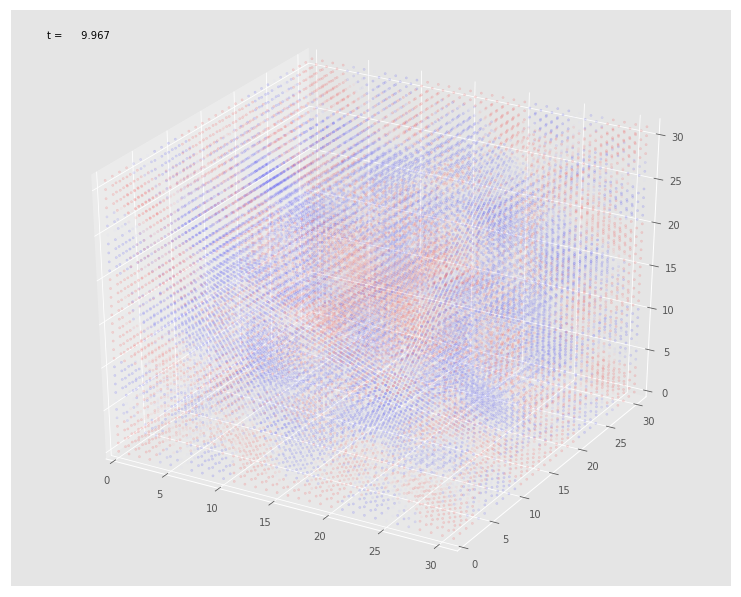

In [9]:
# draw
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

x = np.array(range(0,Nx+1))
y = np.array(range(0,Ny+1))
z = np.array(range(0,Nz+1))

X,Y,Z = np.meshgrid(x,y,z)

plt_X = X.reshape((-1,))
plt_Y = Y.reshape((-1,))
plt_Z = Z.reshape((-1,))

def init():
    return tuple()


interval = 1000 / render_fps
frames = T * render_fps

pbar = tqdm(total=frames)
cmhot = plt.cm.get_cmap('bwr')

ttl = ax.text2D(0.05, 0.95, "", transform=ax.transAxes)
graph = ax.scatter(plt_X,plt_Y,plt_Z,s=plt_size,alpha=plt_alpha,color='black')
graph.set_cmap(cmhot)

ax.set_xbound(0 - 0.1,Nx + 0.1)
ax.set_ybound(0 - 0.1,Ny + 0.1)
ax.set_zbound(0 - 0.1,Nz + 0.1)

Cmin = -0.1
Cmax = 0.1
print(Cmin,Cmax)

def animate(frame):
    pbar.update(1)
    n = int(frame * compute_fps / render_fps)
    C = u[n,:,:,:]
    
    plt_C = list(map(lambda x: cmhot((x - Cmin)/(Cmax-Cmin),plt_alpha),C.reshape((-1,))))
    ttl.set_text('t = {:10.3f}'.format(n * ht))
    
    graph._facecolor3d = plt_C
    graph._edgecolor3d = plt_C
    
    
print('rendering image')

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, init_func=init, blit=False)

create_if_not_exists('./movies-4d')
number = 0

plt.show()